# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75.

## Изучение данных

### Импортируем необходимые библиотеки

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

### Считываем данные

In [7]:
users_df = pd.read_csv('D:/3D Objects/Praktikum/Data/users_behavior.csv')
print(users_df.info())
users_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB
None


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Имеем таблицу с 3214 строками, пропусков нет.

Предстоит предсказывать значения столбца **is_ultra** по значениям в других столбцах.

### Описание данных
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:

- **сalls** — количество звонков,
- **minutes** — суммарная длительность звонков в минутах,
- **messages** — количество sms-сообщений,
- **mb_used** — израсходованный интернет-трафик в Мб,
- **is_ultra** — каким тарифом пользовался в течение месяца («Ультра» — **1**, «Смарт» — **0**).

## Разбиение на выборки

Для разделения данных на обучающую, валидационную и тестовую выборки, воспользуемся функцией trail_test_split библиотеки sklearn. 

Т.к. нет отдельных тестовых данных, разделение проведем следующим образом:
- **60%** Обучающая выборка
- **20%** Валидационная выборка
- **20%** Тестовая выборка

In [8]:
df_train, df_test_and_valid = train_test_split(users_df, test_size=0.4, random_state=42)
df_valid, df_test = train_test_split(df_test_and_valid, test_size=0.5, random_state=42)
print('train lenght:', len(df_train))
print('valid lenght:', len(df_valid))
print('test lenght',len(df_test))

train lenght: 1928
valid lenght: 643
test lenght 643


Разбили датасет в нужных пропорциях. Теперь каждую таблицу разделим еще на две: в одной будут **признаки**, по которым будет определяться целевой признак (**features**), а в другой - сам **целевой признак** (**target**).

Для удобства, создадим функцию **features_target_split**, которая будет получать на вход датасет и целевой признак, а на выходе давать две таблицы.

In [9]:
def features_target_split(data, target):
    features = data.drop([target], axis=1)
    target = data[target]
    return features, target

train_features, train_target = features_target_split(df_train, 'is_ultra')
valid_features, valid_target = features_target_split(df_valid, 'is_ultra')
test_features, test_target = features_target_split(df_test, 'is_ultra')

Также подготовим объединенный датасет из обучающей выборки и валидационной, чтобы модели лучше обучились перед финальным тестированием

In [10]:
final_features = train_features.append(valid_features)
final_target = train_target.append(valid_target)
len(final_features)

2571

## 3. Исследование моделей

Поскольку перед нами стоит задача классификации, для построения моделей используем три алгоритма:\
**Решающее дерево, Случайный лес, и Логистическую регрессию**.\
Для оценки качества получаемых моделей будем использовать метрику **accuracy.**

### Решающее дерево

Импортируем соответствующую структуру данных и обучим модель

In [11]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=42)
model.fit(train_features, train_target)
accuracy_score(model.predict(valid_features), valid_target)

0.7278382581648523

Получаем в целом неплохую точность даже без настройки гиперпараметров - **0.728**, при требуемых **0.75**.\
Подберем **максимальную глубину** дерева, дающую наибольшую точность на валидационной выборке.

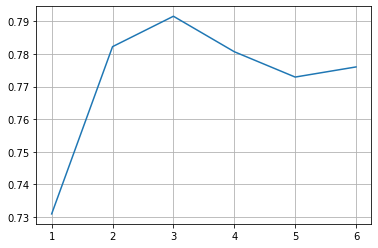

In [12]:
accuracy_data=[]
for i in range(6):
    model = DecisionTreeClassifier(random_state=42, max_depth=i+1)
    model.fit(train_features, train_target)
    accuracy = accuracy_score(model.predict(valid_features), valid_target)
#    print('max_depth:', i+1, '-', accuracy)
    accuracy_data.append(accuracy)
plt.figure()
plt.grid(True)
plt.plot(np.arange(1,7,1), accuracy_data)
plt.show()

Получаем маскимальную точность - **0.79** - при значении максимальной глубины дерева - **3**.\
Посмотрим, сможем ли увеличить точность путем изменения **минимального числа объектов в листе** (**min_samples_leaf**).

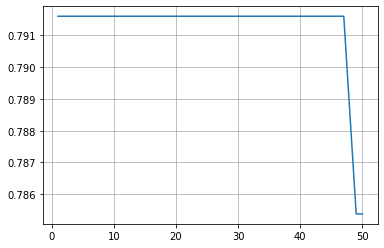

In [13]:
accuracy_data = []
for i in range(50):
    model = DecisionTreeClassifier(max_depth=3, min_samples_leaf=i+1)
    model.fit(train_features, train_target)
    accuracy = accuracy_score(model.predict(valid_features), valid_target)
#    print('max_depth:', i+1, '-', accuracy)
    accuracy_data.append(accuracy)
plt.figure()
plt.grid(True)
plt.plot(np.arange(1,51,1), accuracy_data)
plt.show()

Видим, что увеличение минимального числа объектов в листе приводит к снижению точности, поэтому оставим этот гиперпараметр без изменений.

---

### <span style="color:teal">Проверка на переобучение<span>

Сравним точность на валидационной и тренировочной выборках:

In [14]:
model = DecisionTreeClassifier(max_depth=3)
model.fit(train_features, train_target)
print('accuracy train', accuracy_score(model.predict(train_features), train_target))
print('accuracy valid', accuracy_score(model.predict(valid_features), valid_target))

accuracy train 0.7971991701244814
accuracy valid 0.7916018662519441


Точность на обучающей и валидационной выборках очень близки, значит нет ни переобучения, ни недообучения.

Сохраним модель решающего дерева с оптимальными параметрами для дальнейшей проверки на тестовой выборке:

In [16]:
# обучаем на датасете из обучающей выборки + валидационной
model_decision_tree = DecisionTreeClassifier(random_state=42, max_depth=3)
model_decision_tree.fit(final_features, final_target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

### Случайный лес

In [17]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42, n_estimators=10)
model.fit(train_features, train_target)
accuracy_score(model.predict(valid_features), valid_target)

0.7869362363919129

С первой итерации получаем точность больше необходимой - **0.787**.\
Попробуем увеличить ее, меняя число деревьем, максимальную глубину и число минимальных объектов в листе.

**Максимальная глубина:**

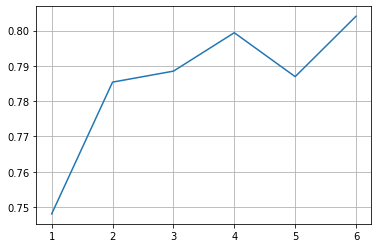

In [18]:
accuracy_data=[]
for i in range(6):
    model = RandomForestClassifier(random_state=42, max_depth=i+1, n_estimators=10)
    model.fit(train_features, train_target)
    accuracy = accuracy_score(model.predict(valid_features), valid_target)
#    print('max_depth:', i+1, '-', accuracy)
    accuracy_data.append(accuracy)
plt.figure()
plt.grid(True)
plt.plot(np.arange(1,7,1), accuracy_data)
plt.show()

Получаем оптимальное значение **max_depth = 6**.

**Число деревьев:**

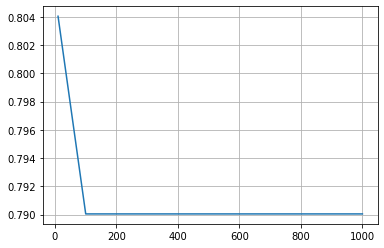

In [19]:
n_estimators_list = [10, 100, 1000]
accuracy_data=[]
for i in n_estimators_list:
    model = RandomForestClassifier(random_state=42, max_depth=6, n_estimators=i)
    model.fit(train_features, train_target)
    accuracy = accuracy_score(model.predict(valid_features), valid_target)
#    print('n_estimators', i, '-', accuracy)    
    accuracy_data.append(accuracy)
plt.figure()
plt.grid(True)
plt.plot(n_estimators_list, accuracy_data)
plt.show()

Судя по всему, нет смысла брать больше **100** деревьев, т.к. время ожидания будет высоко, а результат непостоянен (при изменении значения **random_state** выигрышным может оказаться любое число деревьев).

**Минимальное число объектов в листе:**

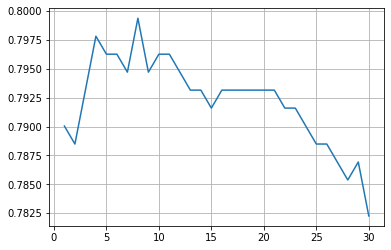

In [20]:
accuracy_data=[]
for i in range(30):
    model = RandomForestClassifier(random_state=42, max_depth=6, n_estimators=100, min_samples_leaf=i+1)
    model.fit(train_features, train_target)
    accuracy = accuracy_score(model.predict(valid_features), valid_target)
#    print('min_samples_leaf:', i+1, '-', accuracy)
    accuracy_data.append(accuracy)
plt.figure()
plt.grid(True)
plt.plot(np.arange(1,31,1), accuracy_data)
plt.show()

Видим, что изменение значения **min_samples_leaf** не дает однозначных результатов (точность варьируется в небольших пределах, а максимум на графике будет меняться в зависимости от параметра **random_state**), поэтому оставим этот гиперпараметр без изменений.

### <span style="color:teal">Проверка на переобучение<span>

Сравним точность на валидационной и тренировочной выборках:

In [21]:
model = RandomForestClassifier(random_state=42, max_depth=6, n_estimators=100)
model.fit(train_features, train_target)
print('accuracy train', accuracy_score(model.predict(train_features), train_target))
print('accuracy valid', accuracy_score(model.predict(valid_features), valid_target))

accuracy train 0.8262448132780082
accuracy valid 0.7900466562986003


Точность на обучающей и валидационной выборках достаточно близки, значит нет ни переобучения, ни недообучения.

---
Сохраним модель случайного леса с оптимальными параметрами для дальнейшей проверки на тестовой выборке:

In [22]:
model_random_forest = RandomForestClassifier(random_state=42, max_depth=6, n_estimators=100)
model_random_forest.fit(final_features, final_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

### Логистическая регрессия

In [23]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear')
model.fit(train_features, train_target)
accuracy_score(model.predict(valid_features), valid_target)

0.7200622083981337

Получаем недостаточную точность. Попробуем, увеличить её, применяя разные алгоритмы (**solver**), а также увеличив значение **max_iter** до **10000**, увеличив таким образом точность.

D:\Programs\Anaconda\lib\site-packages\scipy\optimize\linesearch.py:426: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
D:\Programs\Anaconda\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\Programs\Anaconda\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


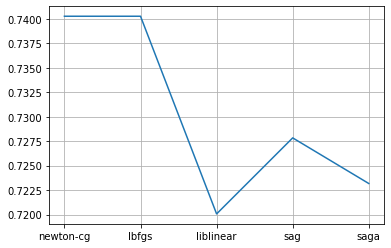

In [24]:
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

accuracy_data = []
for solver in solvers:
    model = LogisticRegression(solver=solver, max_iter=10000)
    model.fit(train_features, train_target)
    accuracy = accuracy_score(model.predict(valid_features), valid_target)
#    print(solver, '-', accuracy)
    accuracy_data.append(accuracy)
plt.figure()
plt.grid(True)
plt.plot(solvers, accuracy_data)
plt.show()

Наибольшая точность - **0.74** - у алгоритмов **newton-cg** и **lbfgs**.\
Оставим последний, поскольку он быстрее (впрочем, разница в скорости совсем незаметна).

### <span style="color:teal">Проверка на переобучение<span>

Сравним точность на валидационной и тренировочной выборках:

In [25]:
model = LogisticRegression(solver='lbfgs', max_iter=10000)
model.fit(train_features, train_target)
print('accuracy train', accuracy_score(model.predict(train_features), train_target))
print('accuracy valid', accuracy_score(model.predict(valid_features), valid_target))

accuracy train 0.7432572614107884
accuracy valid 0.7402799377916018


Точность на обучающей и валидационной выборках крайне близки, значит нет ни переобучения, ни недообучения.

Сохраним модель леса с оптимальными параметрами для дальнейшей проверки на тестовой выборке:

In [26]:
model_logistic_regression = LogisticRegression(solver='lbfgs', max_iter=10000)
model_logistic_regression.fit(final_features, final_target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Проверка на тестовой выборке

In [27]:
models = [model_decision_tree, model_random_forest, model_logistic_regression]
models_name = ['decision_tree', 'random_forest', 'logistic_regression']
n=0
for model in models:
    print(models_name[n], '-', accuracy_score(model.predict(test_features), test_target))
    n+=1

decision_tree - 0.8055987558320373
random_forest - 0.8164852255054432
logistic_regression - 0.702954898911353


## Вывод

- Лучшй результат показала модель **Случайного леса** - точность **0.816**.
- Следующей по точности идет модель **Решающего дерева** с точностью **0.806**.
- **Логистическая регрессия** показала неудовлетворительный результат - **0.703**.

## 5. Проверка моделей на адекватность

Для метода проверки модели определим соотношение числа тарифов:

In [28]:
users_df.is_ultra.sum() / len(users_df)

0.30647168637212197

Выходит, только 30% пользователей пользуются тарифом **"Ультра"**.\
Значит, для проверки адекватности выбранной модели (**Случайный лес**) сравним получившиеся модели с моделью, предлагающей только тариф **"Смарт"**.

In [29]:
print('forest model', accuracy_score(model_random_forest.predict(test_features), test_target))
print('random model', accuracy_score(np.zeros(len(test_features)).astype(int), test_target))

forest model 0.8164852255054432
random model 0.6967340590979783


Видим, что построенная модель имеет точность больше чем у константной модели, значит проходит проверку на адекватность.